In [1]:
import pickle as pkl
import numpy as np

from src.models.train_emos import train_emos, train_and_test_emos
from src.visualization.pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from src.visualization.brier_score import make_brier_skill_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from src.visualization.scoring_tables import make_table
from src.visualization.twcrpss_plot import make_twcrpss_plot
from src.models.emos import EMOS
from src.visualization.reliability_diagram import make_reliability_diagram
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_cdf, plot_forecast_pdf

2024-04-03 08:24:58.361547: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 08:24:58.389279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 08:24:58.389296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 08:24:58.389957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 08:24:58.394212: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 08:24:58.394869: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/emos/'

base_model = load_model(folder + 'trunc_normal/tn_crps__epochs600_folds_2_3_mean0_1_2_3_4_std5_.pkl')
print(base_model)

Using given parameters for Truncated Normal distribution
EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 100)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [0.40483156]
  b_tn: [ 0.9529339  -0.11812493 -0.13730761  0.01299615  0.13155769]
  c_tn: [0.7954294]
  d_tn: [0.91627157]
Features: wind_speed, press, kinetic, humid, geopot, spatial_variance
Location features: wind_speed, press, kinetic, humid, geopot
Scale features: spatial_variance
Number of features: 6
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.029999999329447746



In [3]:
test_fold = 3
ignore = ['229', '285', '323']
X_test, y_test = get_tensors(base_model.neighbourhood_size, base_model.all_features, test_fold, ignore)
X_test = (X_test - base_model.feature_mean) / base_model.feature_std

print(X_test.shape)

(7780, 6)


In [4]:
tn_1 = load_model(folder + 'trunc_normal/tn_twcrps_mean13.0_std2.0_epochs600_folds_2_3_mean0_1_2_3_4_std5_.pkl')

gev_1 = load_model(folder + 'gev/gev_twcrps_mean13.0_std2.0_epochs600_folds_2_3_mean0_1_2_3_4_std5_.pkl')

dict = {'tn': tn_1, 'gev': gev_1}



Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution


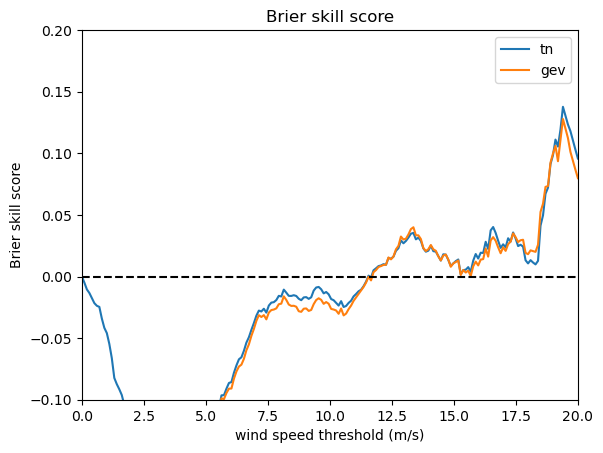

In [5]:
values = np.linspace(0, 20, 200)
ylim = [-0.1,0.2]
make_brier_skill_plot(base_model, dict, X_test, y_test, values, ylim=ylim)

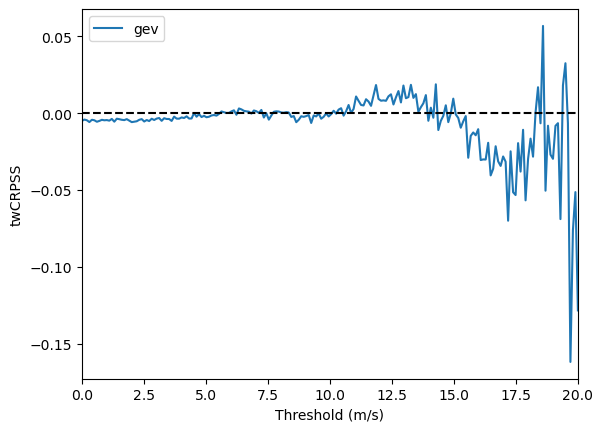

In [31]:
x_values = np.linspace(0, 20, 200)
make_twcrpss_plot(base_model, gev_models, X_test, y_test, variances_test, x_values, sample_size=1000)




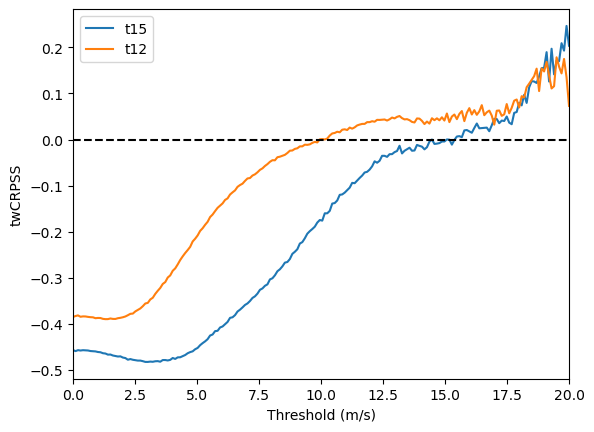

In [9]:
make_twcrpss_plot(base_model, t_models, X_test, y_test, variances_test, x_values, sample_size=1000)

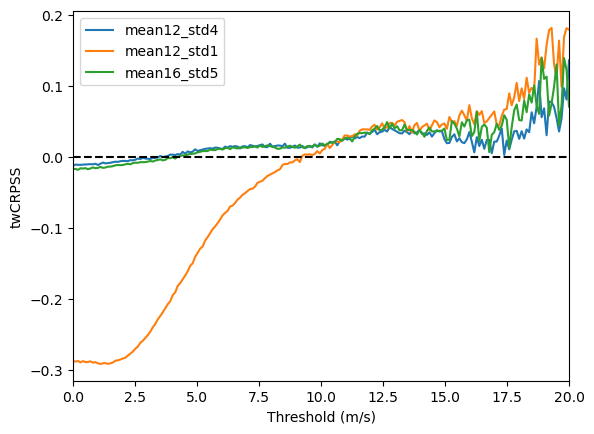

In [10]:
make_twcrpss_plot(base_model, cdf_models, X_test, y_test, variances_test, x_values, sample_size=1000)

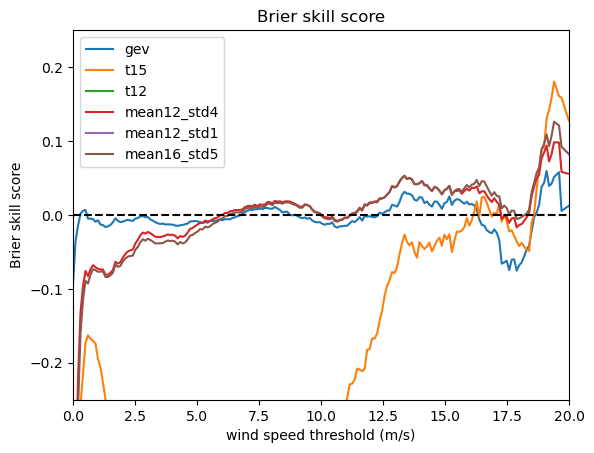

In [32]:
ylim = [-1,1]
#brier_skill_plot(base_model, all_models, X_test, y_test, variances_test, x_values, ylim=ylim)
ylim = [-0.25, 0.25]
brier_skill_plot(base_model, all_models, X_test, y_test, variances_test, x_values)#, ylim=ylim)

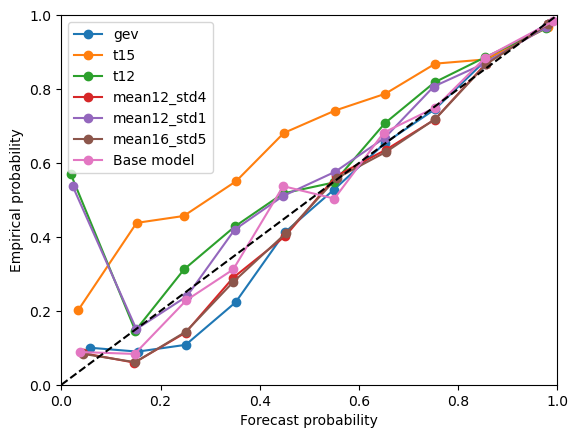

In [13]:
t = 10
make_reliability_diagram(all_models, X_test, y_test, variances_test, t=t, base_model=base_model)

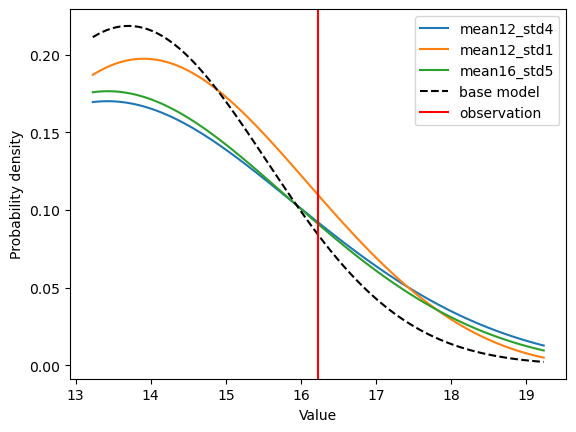

In [29]:
t = 15
plot_forecast_pdf(cdf_models, X_test, y_test, variances_test, observation_value=t, base_model=base_model)